## NOTE: NOT USED IN PAPER

In [1]:
import numpy as np
import pickle
import scipy.io as sio
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import gaussian_kde

In [ ]:
BASE = Path("..") / "res" / "toad" / "posterior_samples"

FILES = {
    "MMD‑ABC": BASE / "mmdabc_posterior_particles.npy",
    "SNL": BASE / "snl_thetas.pkl",
    "RSNL": BASE / "rsnl_thetas.pkl",
    "RNPE": BASE / "rnpe_toad_res.pkl",
    "RBSL": BASE / "results_bsl_model2_realdata_mean_n500.mat",
}

In [ ]:
def to_array(obj):
    """
    Convert many possible SBI / ABC containers to a plain np.ndarray (N,3).

    • Understands NumPy, Torch, **JAX**, nested dicts, tuple‑of‑(samples,weights),
      list/tuple of per‑round samples (uses the LAST round), pandas, xarray…
    • Raises TypeError with a helpful message if it still can’t figure it out.
    """
    import numpy as np

    # 0.  Already a NumPy array?
    if isinstance(obj, np.ndarray):
        return obj

    # 1. Torch tensor?
    try:
        import torch

        if isinstance(obj, torch.Tensor):
            return obj.detach().cpu().numpy()
    except ImportError:
        pass  # torch not installed – ignore

    # 2. JAX DeviceArray?
    try:
        import jax.numpy as jnp
        from jaxlib.xla_extension import ArrayImpl as _JAXArray  # JAX ≥0.4

        if isinstance(obj, _JAXArray):
            return np.asarray(obj)
    except Exception:
        pass

    # 3. pandas / xarray
    try:
        import pandas as pd, xarray as xr

        if isinstance(obj, (pd.Series, pd.DataFrame, xr.DataArray, xr.Dataset)):
            return obj.to_numpy()
    except ImportError:
        pass

    # 4. Sequence container – iterate LAST→FIRST so “final round” wins
    if isinstance(obj, (list, tuple)):
        for item in reversed(obj):
            try:
                arr = to_array(item)  # recurse
                if arr.ndim == 2 and arr.shape[1] == 3:
                    return arr
            except Exception:
                continue  # keep looking
        # Fall through if no element matched

    # 5. Mapping / dict – look for common keys or recurse on values
    if isinstance(obj, dict):
        # named keys first
        for key in (
            "theta",
            "thetas",
            "samples",
            "posterior_samples",
            "thetaSamples",
            "post_theta",
        ):
            if key in obj:
                try:
                    return to_array(obj[key])
                except Exception:
                    pass
        # otherwise any value that converts nicely
        for val in obj.values():
            try:
                arr = to_array(val)
                if arr.ndim == 2 and arr.shape[1] == 3:
                    return arr
            except Exception:
                continue

    # 6. Last‑ditch: anything array‑like (has __array__ interface)
    try:
        arr = np.asarray(obj)
        if arr.ndim == 2 and arr.shape[1] == 3:
            return arr
    except Exception:
        pass

    raise TypeError(
        "😕  Could not coerce object of type "
        f"{type(obj)} to an (N,3) NumPy array.  "
        "Inspect the pickle/mat file manually and extend `to_array()` if needed."
    )

In [ ]:
posteriors = {}
for name, path in FILES.items():
    if not path.exists():
        raise FileNotFoundError(f"{path} not found")
    if path.suffix == ".npy":
        posteriors[name] = to_array(np.load(path, allow_pickle=True))
    elif path.suffix in {".pkl", ".pickle"}:
        with open(path, "rb") as h:
            posteriors[name] = to_array(pickle.load(h))
    elif path.suffix == ".mat":
        mat = sio.loadmat(path)
        posteriors[name] = to_array(mat)  # let to_array dig the samples out
    else:
        raise ValueError(f"Unknown file type for {path}")
    if posteriors[name].ndim > 2:  # assume first axis is num_chains
        posteriors[name] = posteriors[name].reshape(-1, 3)
    if posteriors[name].shape[1] != 3:
        raise ValueError(
            f"{name}: expected 3 parameters, got shape {posteriors[name].shape}"
        )

In [13]:
np.mean(posteriors["SNL"], axis=0)

array([ 1.7952658, 49.169895 ,  0.6998238], dtype=float32)

In [ ]:
import os

pkl_path = "../res/toad/posterior_samples/rnpe_toad_res.pkl"
print("Exists? ", os.path.exists(pkl_path))
print("Size (bytes):", os.path.getsize(pkl_path))

Exists?  True
Size (bytes): 24586648


In [ ]:
with open("../res/toad/posterior_samples/rnpe_toad_res.pkl", "rb") as f:
    rnpe_res = pickle.load(f)
posteriors["RNPE"] = (
    np.array(rnpe_res["posterior_samples"]["RNPE"]).flatten().reshape(-1, 3)
)

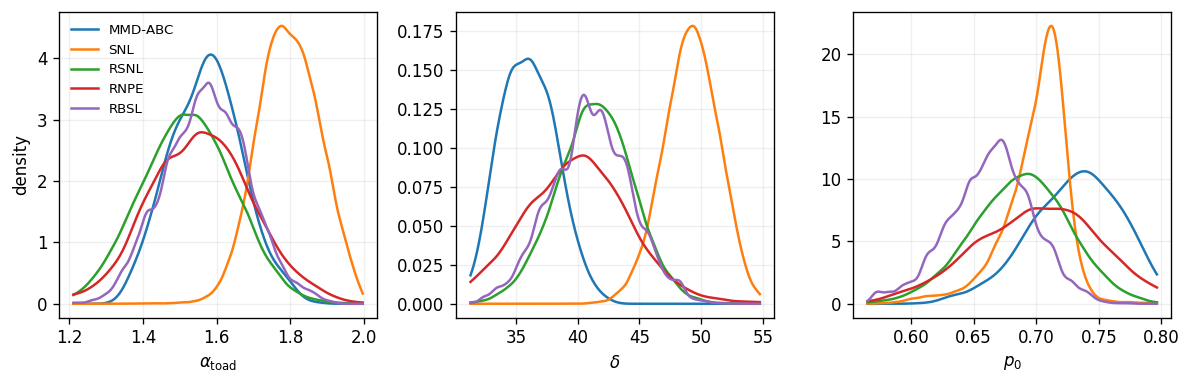

In [ ]:
param_labels = [r"$\alpha_{\mathrm{toad}}$", r"$\delta$", r"$p_0$"]

plt.rcParams["figure.dpi"] = 120
colors = plt.cm.tab10.colors  # 5 colour‑blind‑safe hues

fig, axes = plt.subplots(1, 3, figsize=(10, 3.3), sharey=False)

for j, ax in enumerate(axes):
    # unified grid so tails are comparable
    grid = np.hstack([p[:, j] for p in posteriors.values()])
    lo, hi = np.percentile(grid, [0.5, 99.5])
    xs = np.linspace(lo - 0.05 * (hi - lo), hi + 0.05 * (hi - lo), 512)

    for c, (method, samples) in zip(colors, posteriors.items()):
        from scipy.stats import gaussian_kde

        kde = gaussian_kde(samples[:, j])
        ax.plot(xs, kde(xs), lw=1.5, color=c, label=method)

    ax.set_xlabel(param_labels[j])
    if j == 0:
        ax.set_ylabel("density")
    # ax.set_title(f"{param_labels[j]}")
    ax.grid(alpha=0.2)

axes[0].legend(frameon=False, fontsize=8)
plt.tight_layout()
plt.savefig("figs/toad_posterior_marginals.pdf", bbox_inches="tight")
# plt.suptitle("Fowler’s toad – posterior marginals (5 methods)", y=1.03, fontsize=12)
plt.show()